### Social Media Virality using Networks

In [22]:
# import
import networkx as nx
import random
import matplotlib.pyplot as plt
import matplotlib.colors
import time
from IPython.display import clear_output

### Initializing the model

In [39]:
def initialize(online_probability=0.8):

  num_nodes = 50
  global peak_virality

  peak_virality = 1

  network = nx.watts_strogatz_graph(num_nodes, k=5, p=0.2)

  # initialize all nodes to have not seen or shared the post
  for node in network.nodes():
    network.nodes[node]['seen_post'] = 0
    network.nodes[node]['shared_post'] = 0
    network.nodes[node]['time_shared'] = 0

    # initialize about 80% of the network to be online
    if random.random() < online_probability:
      network.nodes[node]['online'] = 1
    else:
      network.nodes[node]['online'] = 0

  # select initial node to share post
  initial_sharer = random.choice(list(network.nodes()))
  network.nodes[initial_sharer]['shared_post'] = 1
  network.nodes[initial_sharer]['seen_post'] = 1
  network.nodes[initial_sharer]['online'] = 1


  network.pos = nx.kamada_kawai_layout(network)
  return network

### Observing the initial network

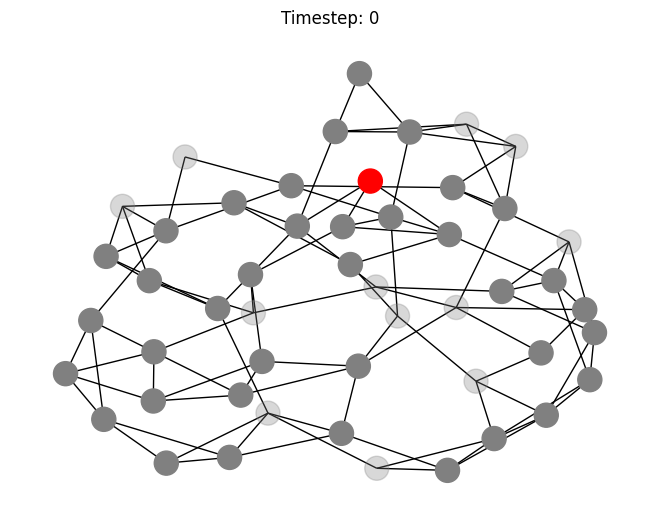

In [40]:
# Observe the initial network
def observe(network, timestep):
  node_colors = []
  for node in network.nodes():
    if network.nodes[node]['shared_post'] == 1:
      color = 'red'
    elif network.nodes[node]['seen_post'] == 1:
      color = 'yellow'
    else:
      color = 'gray'

    alpha = 1.0 if network.nodes[node]['online'] == 1 else 0.3
    rgba_color = matplotlib.colors.to_rgba(color, alpha)
    node_colors.append(rgba_color)

  #plt.figure(figsize=(12,8))
  nx.draw(network, pos=network.pos, node_color=node_colors, with_labels=False)
  plt.title(f"Timestep: {timestep}")
  plt.show()


network = initialize()
observe(network, 0)

### Updating the model

In [41]:
def update_network(network, sharing_prob=0.8, flip_prob=0.2, shared_duration=10):
    global peak_virality

    # For each node that is sharing, mark all online neighbors as having seen the post
    for node in network.nodes():
        if network.nodes[node]['shared_post'] == 1:
            for neighbor in network.neighbors(node):
                if network.nodes[neighbor]['online'] == 1:
                    network.nodes[neighbor]['seen_post'] = 1

    # Flip online status with a certain probability
    for node in network.nodes():
        if random.random() < flip_prob:
            network.nodes[node]['online'] = 1 - network.nodes[node]['online']

        # If a node has shared the post, increase the time shared
        if network.nodes[node]['shared_post'] == 1:
            network.nodes[node]['time_shared'] += 1

            # If shared duration is reached, remove the post and reset time shared
            if network.nodes[node]['time_shared'] >= shared_duration:
                network.nodes[node]['shared_post'] = 0
                network.nodes[node]['time_shared'] = 0
                # # Set adjacent nodes to not seen
                # for neighbor in network.neighbors(node):
                #     network.nodes[neighbor]['seen_post'] = 0

    # Spread the post
    for node in network.nodes():
        # Check if node is online and has seen but not shared the post
        if network.nodes[node]['online'] == 1 and network.nodes[node]['seen_post'] == 1 and network.nodes[node]['shared_post'] == 0:
            # Node decides to share the post based on sharing probability
            if random.random() < sharing_prob:
                network.nodes[node]['shared_post'] = 1
                network.nodes[node]['time_shared'] = 1  # Reset time shared

                # Neighbors of the node now see the post
                for neighbor in network.neighbors(node):
                    if network.nodes[neighbor]['online'] == 1:
                        network.nodes[neighbor]['seen_post'] = 1


    # Count the current number of sharers
    current_sharers = sum(1 for node in network.nodes() if network.nodes[node]['shared_post'] == 1)

    # Update peak virality if the current number of sharers is greater than the peak
    if current_sharers > peak_virality:
        peak_virality = current_sharers

    return peak_virality




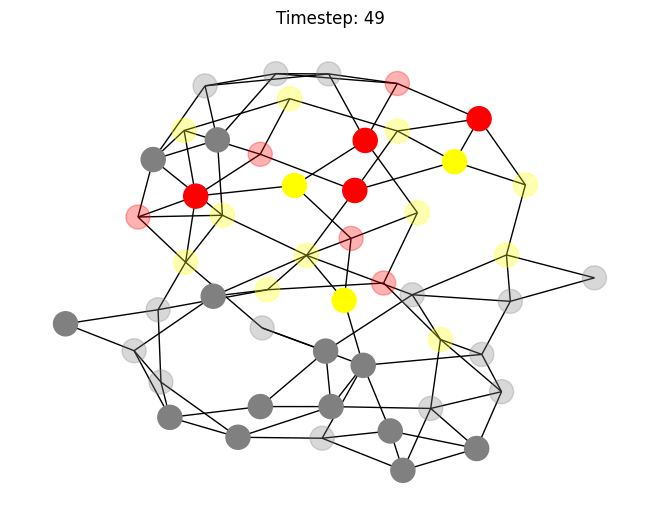

Peak virality: 9


In [42]:
def run_simulation(timesteps=50, sharing_prob=0.1, flip_prob=0.2):
    global peak_virality
    # Initialize the network
    network = initialize()

    # Run the simulation
    for t in range(timesteps):
        update_network(network, sharing_prob, flip_prob)
        clear_output(wait=True)
        observe(network, t)
        time.sleep(0.5)

    # Print the peak virality after the simulation
    print(f"Peak virality: {peak_virality}")


# Run the entire simulation
run_simulation()


### Parameter sweep

[[ 4.  6.  6. 11. 13. 11. 15. 17. 19.]
 [ 4.  9. 10.  9. 14. 14. 16. 19. 18.]
 [ 7. 10. 13. 17. 20. 22. 22. 21. 23.]
 [ 7.  8. 18. 18. 24. 25. 29. 27. 28.]
 [ 9.  9. 19. 24. 23. 27. 26. 25. 33.]
 [11. 14. 19. 27. 24. 29. 34. 35. 33.]
 [16. 18. 22. 27. 28. 31. 35. 35. 37.]
 [12. 20. 27. 23. 31. 31. 33. 35. 38.]
 [15. 18. 25. 28. 32. 39. 36. 35. 36.]
 [12. 23. 33. 29. 34. 34. 39. 35. 40.]]


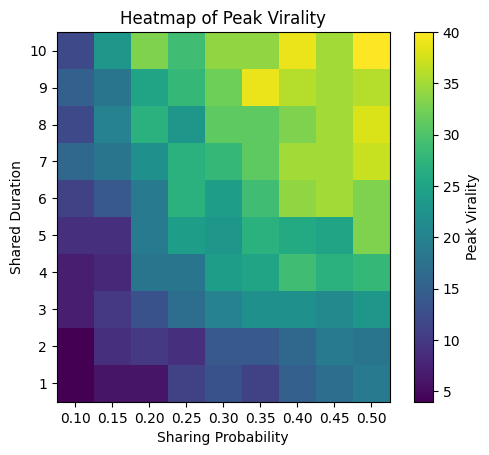

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Adjust run_simulation to accept sharing_prob and shared_duration, and to return peak_virality
def run_sweep(network, timesteps=50, sharing_prob=0.1, flip_prob=0.2, shared_duration=10):
    global peak_virality
    peak_virality = 0
    for t in range(timesteps):
        peak_virality = update_network(network, sharing_prob, flip_prob, shared_duration)
    return peak_virality

# Set up the parameter sweep range
sharing_probs = np.arange(0.1, 0.55, 0.05)  # Sharing probability from 0.1 to 0.5
shared_durations = np.arange(1, 11, 1)  # Shared duration from 1 to 10

# Initialize the results matrix
results = np.zeros((len(shared_durations), len(sharing_probs)))

# Run the parameter sweep
for i, shared_duration in enumerate(shared_durations):
    for j, sharing_prob in enumerate(sharing_probs):
        network = initialize()
        peak_virality = run_sweep(network, sharing_prob=sharing_prob, shared_duration=shared_duration)
        results[i, j] = peak_virality

print(results)

# Create a heatmap to visualize the peak virality
fig, ax = plt.subplots()

# Create the heatmap using the results matrix
cax = ax.imshow(results, cmap='viridis', origin='lower')

# Add a colorbar with a label
cbar = fig.colorbar(cax)
cbar.set_label('Peak Virality')

# Set the tick marks for the sharing probability on the x-axis
sharing_probs_labels = np.arange(0.1, 0.55, 0.05)
ax.set_xticks(np.arange(len(sharing_probs_labels)))
ax.set_xticklabels(['{:.2f}'.format(p) for p in sharing_probs_labels])

# Set the tick marks for the shared duration on the y-axis
shared_durations_labels = np.arange(1, 11, 1)
ax.set_yticks(np.arange(len(shared_durations_labels)))
ax.set_yticklabels(['{}'.format(d) for d in shared_durations_labels])

# Label the axes
ax.set_xlabel('Sharing Probability')
ax.set_ylabel('Shared Duration')

# Set the title of the heatmap
ax.set_title('Heatmap of Peak Virality')

# Display the plot
plt.show()
